In [1]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from PIL import Image, ImageEnhance
import requests
from io import BytesIO
from skimage import measure, color, io
from skimage.segmentation import clear_border
from DataManager import DataManager

In [2]:
dm = DataManager()

In [24]:
dm.suppl_data.iloc[500]
img_url = dm.suppl_data.iloc[500]["image_url"]
img_det_url = dm.suppl_data.iloc[500]["image_details_url"]
print(img_url)
print(img_det_url)

https://idr.openmicroscopy.org/webgateway/render_image/1786720/0/0/
http://idr.openmicroscopy.org/webclient/img_detail/1786720


In [4]:
test_url = img_url #"https://idr.openmicroscopy.org/webgateway/render_image/1674841/0/0/"

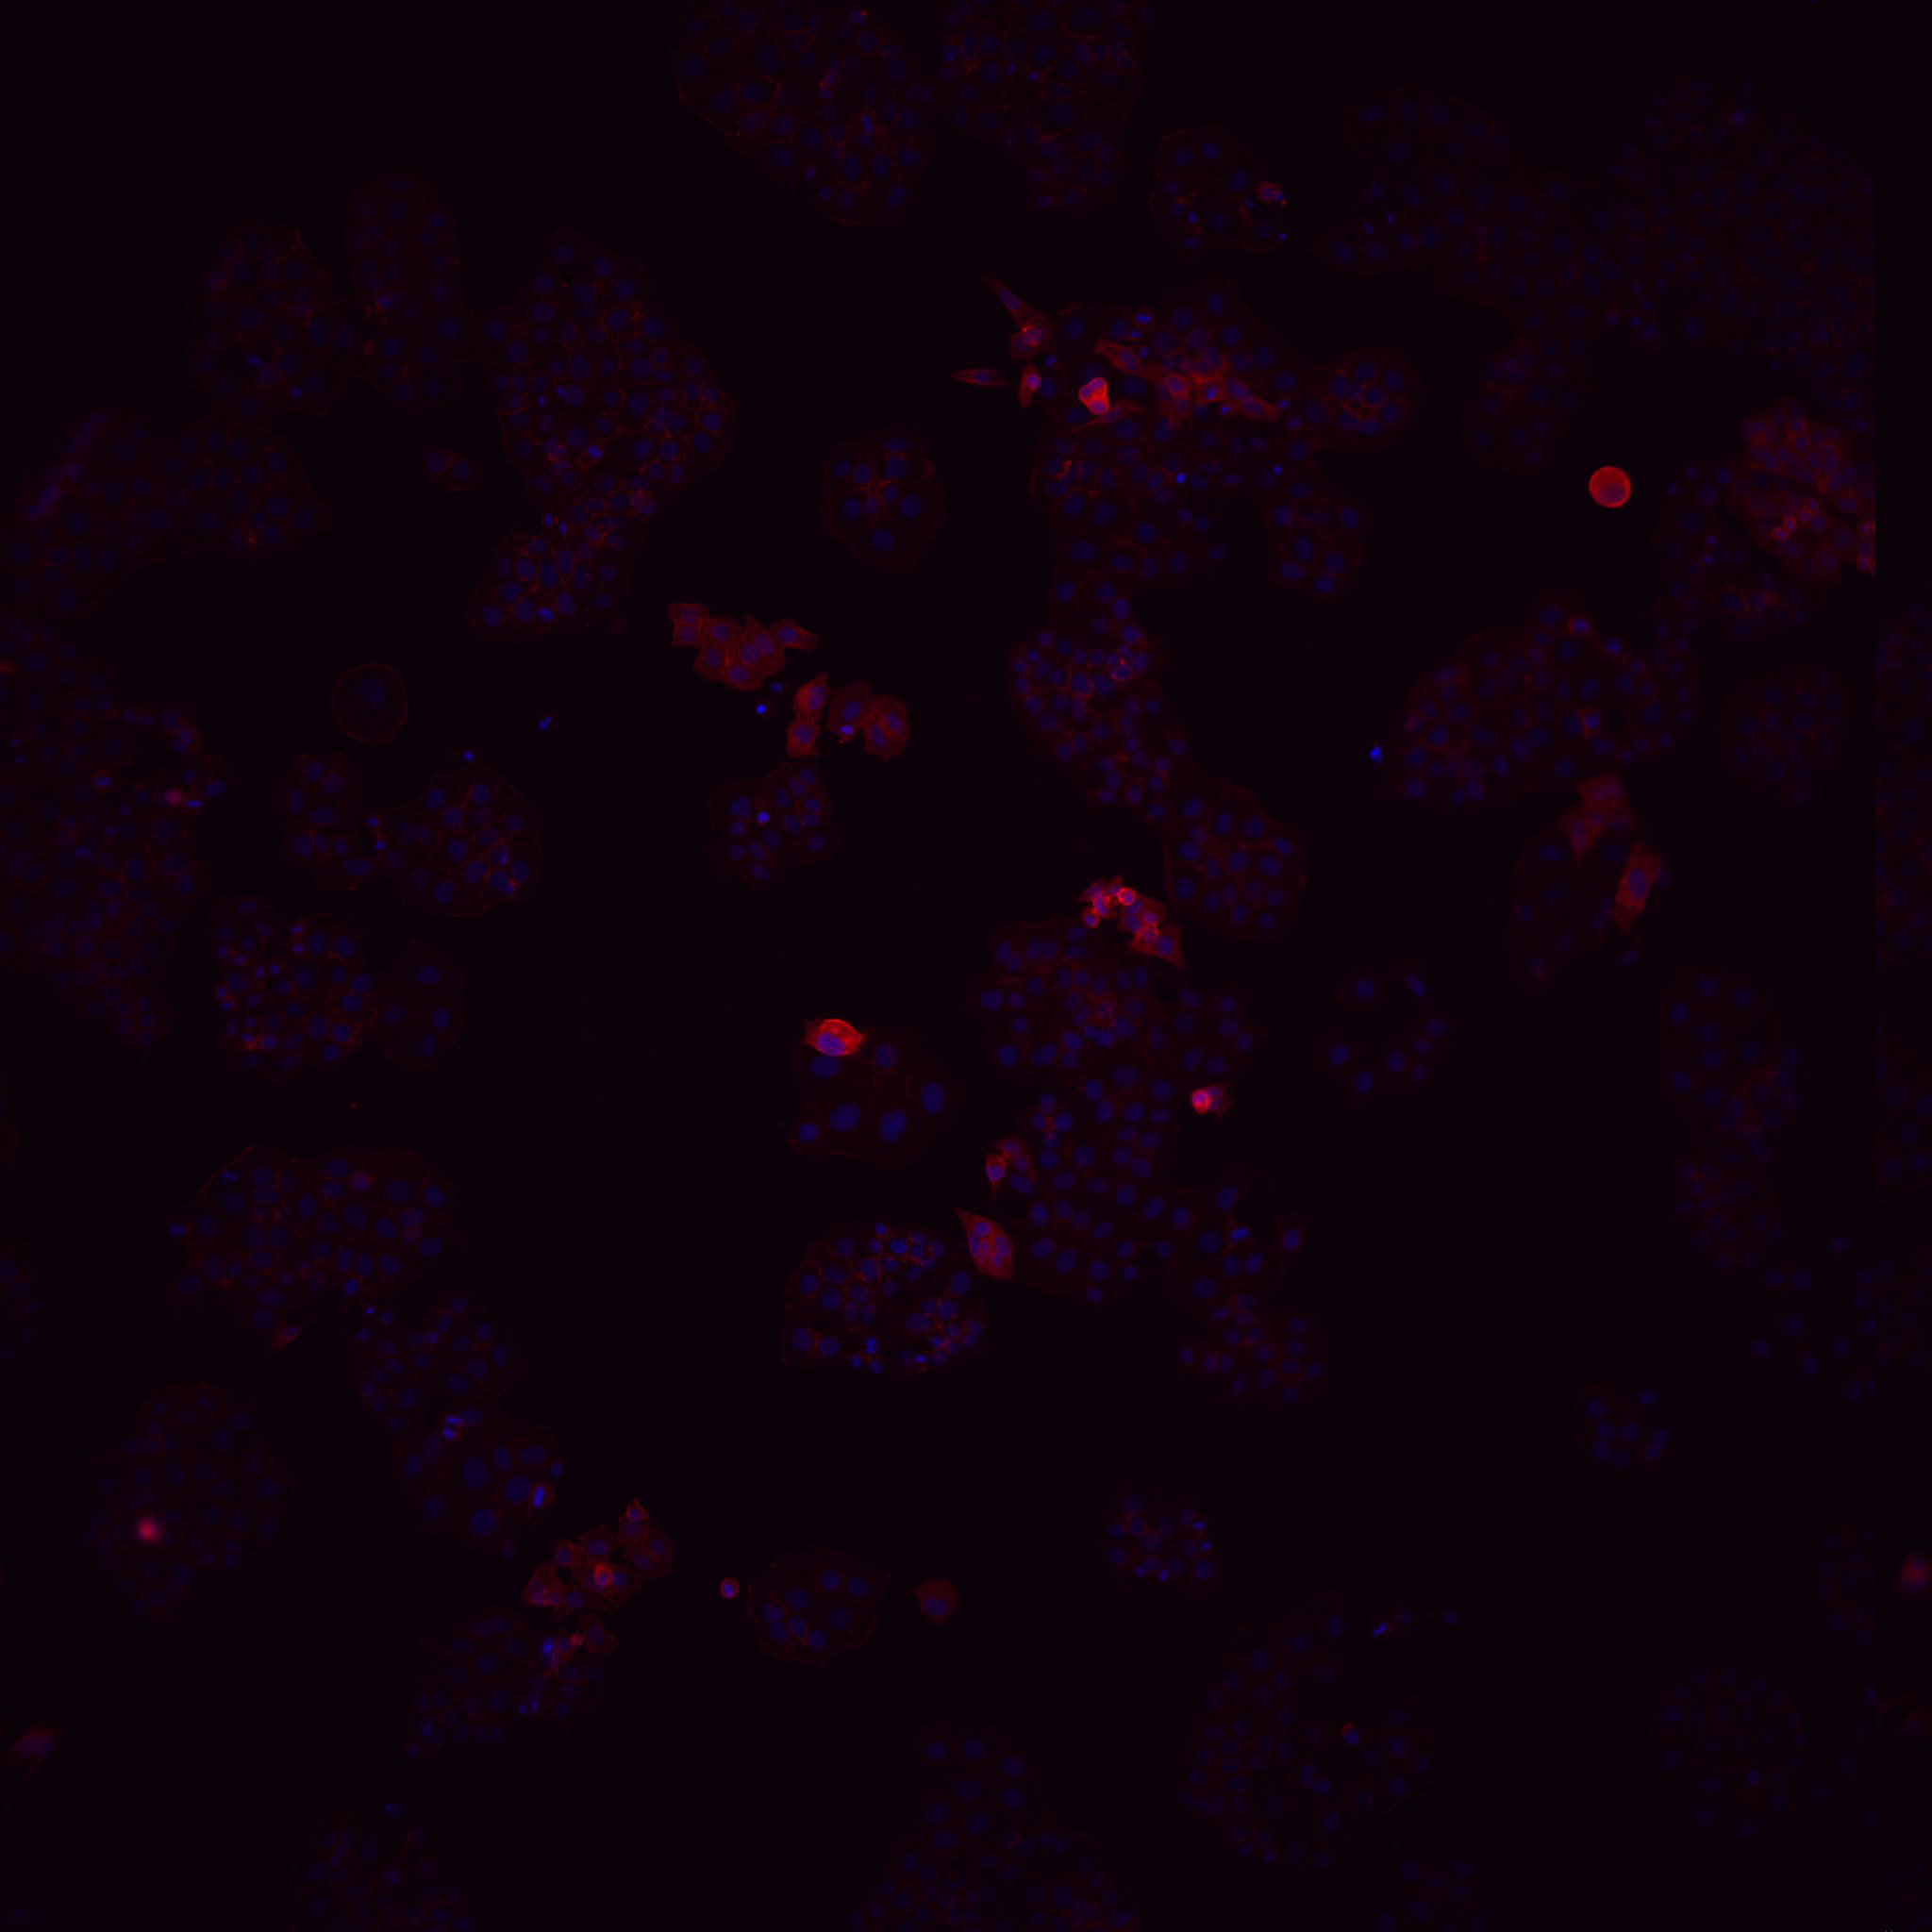

In [5]:
response = requests.get(test_url)
img = Image.open(BytesIO(response.content))
img

In [6]:
# image = io.imread(test_url)
# image.shape

In [7]:
image = io.imread("./data/test_image.tif", plugin='pil')
image2 = io.imread("./data/test_image2.tif", plugin='pil')

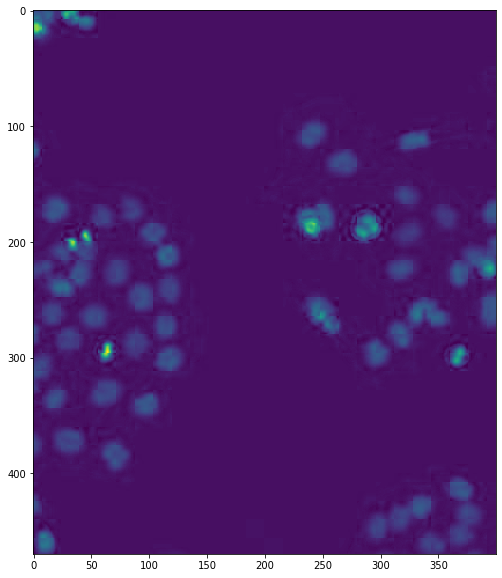

In [8]:
fig=plt.figure(figsize=(10,10))
plt.imshow(image2[1000:1470, 1000:1400, 2])


In [9]:
#gray = cv2.cvtColor(image[1000:1470, 1000:1400, 2],cv2.COLOR_BGR2GRAY)


# img = image[1000:1470, 1000:1400, :].copy()
# original_img = image[1000:1470, 1000:1400, :].copy()
# img_gray = image[1000:1470, 1000:1400, 2].copy()

img = image.copy()
original_img = image.copy()
img_gray = image[:,:, 2].copy()

ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

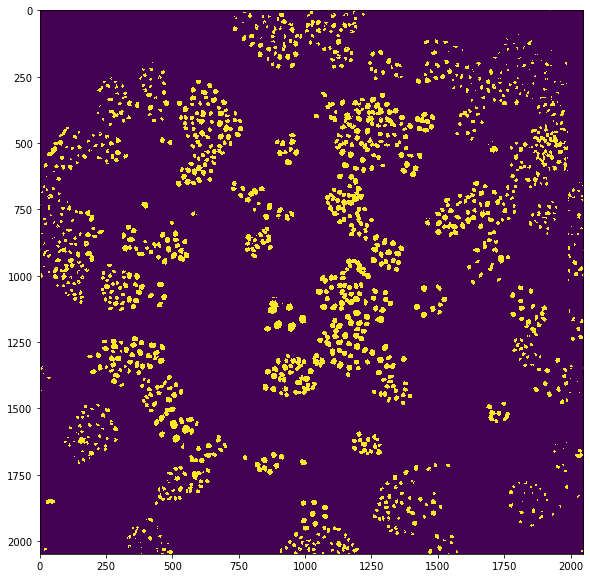

In [10]:
fig=plt.figure(figsize=(10,10))
plt.imshow(thresh)

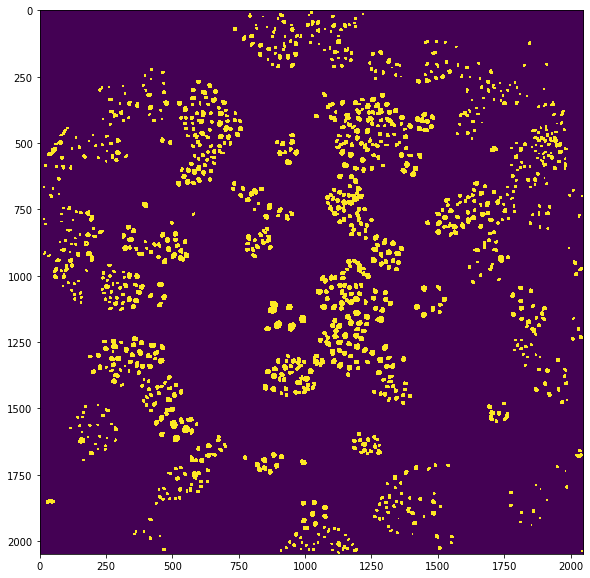

In [11]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 3)
opening = clear_border(opening)

fig=plt.figure(figsize=(10,10))
plt.imshow(opening)

Text(0.5, 1.0, 'Sure FG')

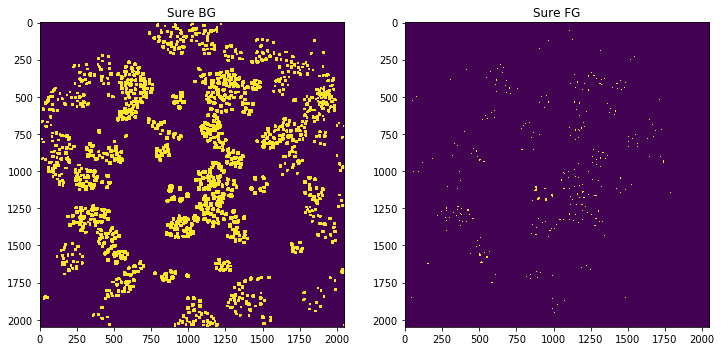

In [12]:
sure_bg = cv2.dilate(opening,kernel,iterations=4)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)


# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(sure_bg)
ax[0].set_title("Sure BG")
ax[1].imshow(sure_fg)
ax[1].set_title("Sure FG")

In [13]:
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers+10
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)

In [14]:
img[markers == -1] = [0,255,255]  
# img_grey2 = img_gray.copy()
# img_grey2[markers == -1] = [255]  

# img2 = color.label2rgb(markers, bg_label=0)

In [15]:
regions = measure.regionprops(markers, intensity_image=img_gray)

# #Can print various parameters for all objects
# for prop in regions:
#     print('Label: {} Area: {}'.format(prop.label, prop.area))

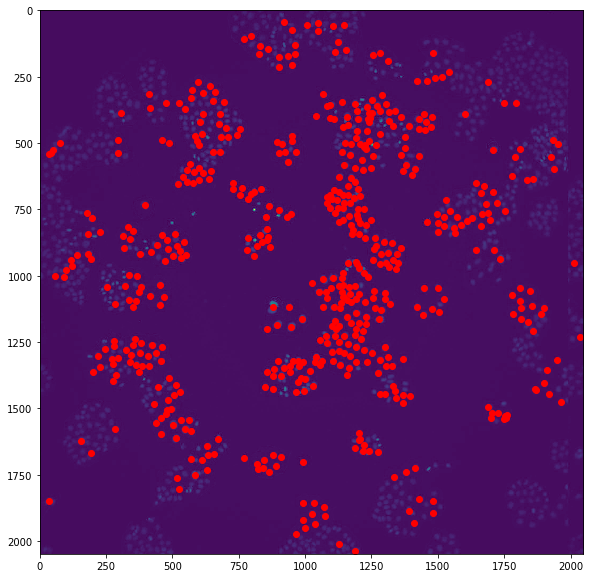

In [16]:
fig=plt.figure(figsize=(10,10))
plt.imshow(img_gray)

centroids_y = [r.centroid[0] for r in regions]
centroids_x = [r.centroid[1] for r in regions]
plt.scatter(centroids_x, centroids_y, c="r")

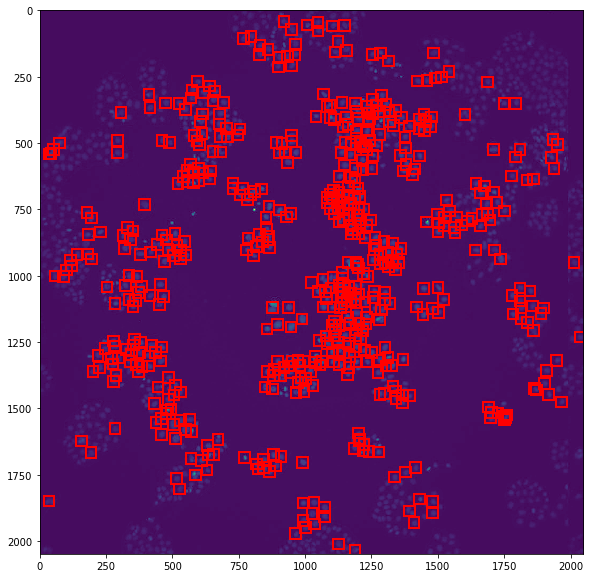

In [17]:
r_height = 40
r_width = 40

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_gray)
rectangles = []
# ax.set_xlim(0,400)
# ax.set_ylim(0,500)
for r in regions:
    cy, cx = r.centroid
    rect = patches.Rectangle((cx-r_width/2,cy-r_height/2),r_width,r_height, 
#                                         linewidth=1,
#                                         edgecolor='r',
#                                         facecolor='none',
                                  lw=2, ec="r", fc="None"
#                                         fill=None
                                       )
    ax.add_patch(rect)
    rectangles.append(rect)

# p = PatchCollection(rectangles)
# ax.add_collection(p)
plt.show()

(1026.4753739141966, 1025.0143447071305)


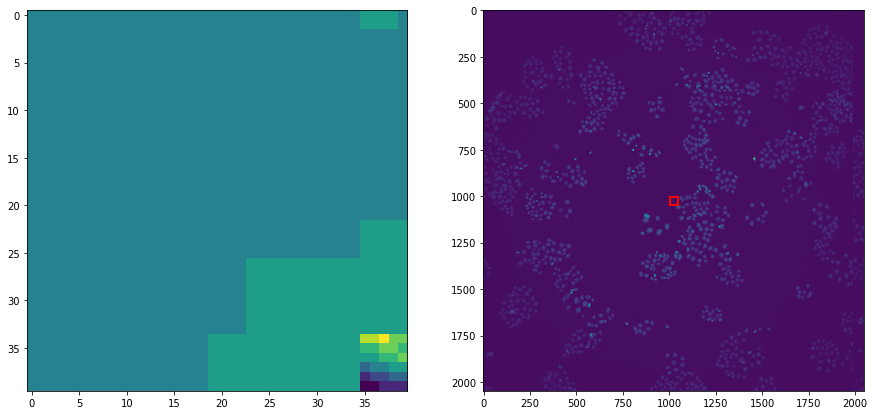

(43.07796610169491, 919.7084745762712)


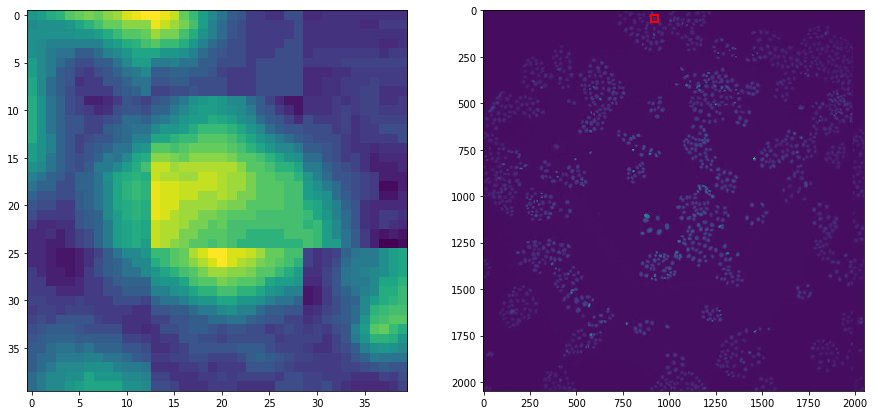

(46.6953125, 1047.77734375)


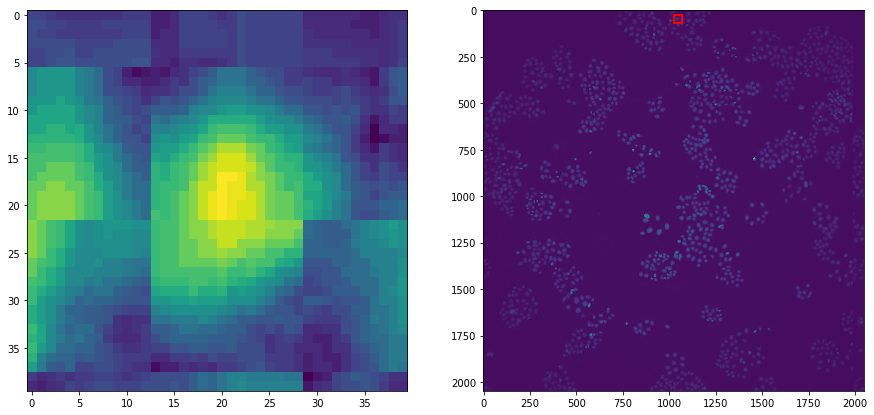

(55.5, 1007.0990099009902)


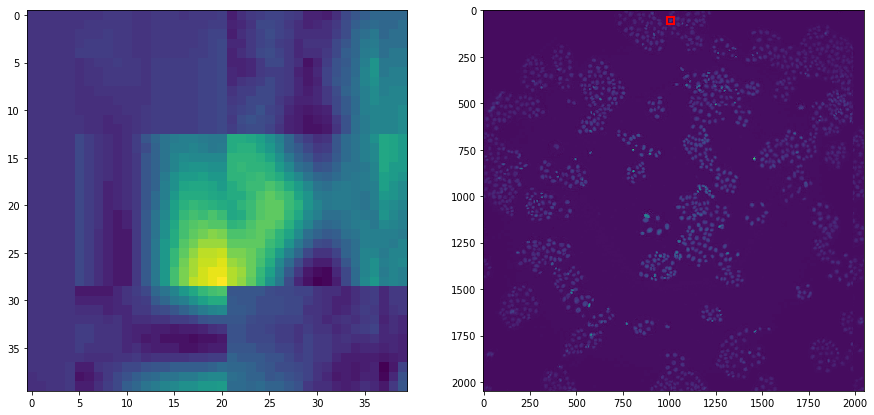

(59.068, 1104.136)


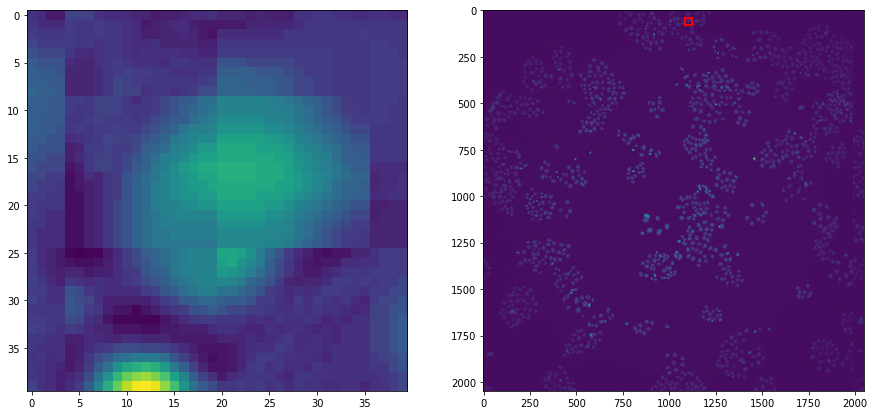

(56.107361963190186, 1147.898773006135)


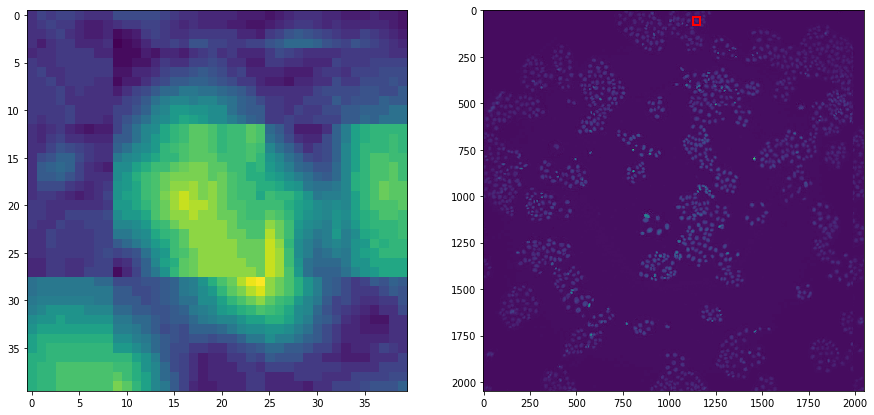

(73.28994082840237, 949.6627218934912)


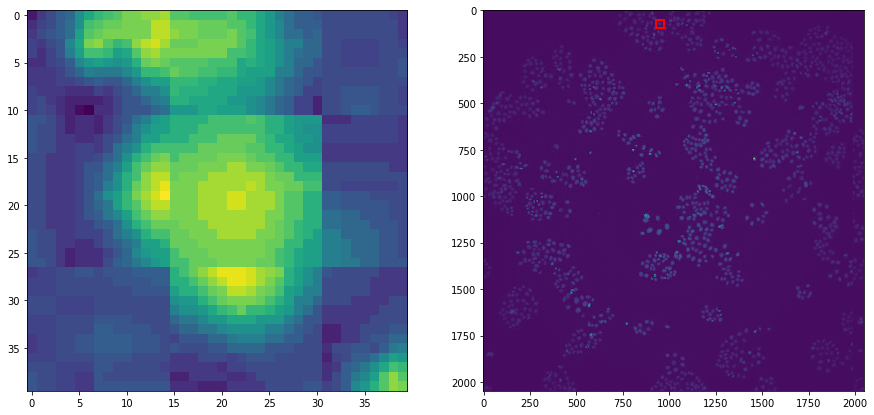

In [22]:
counter = 0
half_patch = 70
for r in regions:
    print(r.centroid)
    try:
        cy, cx = r.centroid
        cx = int(cx)
        cy = int(cy)
        if cx-r_width//2<0 or cx+r_width//2>img.shape[1]:
            continue
        if cy-r_height//2<0 or cy+r_height//2>img.shape[0]:
            continue
        my_patch = original_img[cy-r_height//2:cy+r_height//2, cx-r_width//2:cx+r_width//2, :]
#         my_patch2 = original_img[cy-half_patch:cy+half_patch, cx-half_patch:cx+half_patch, :]
        my_patch = img_gray[cy-r_height//2:cy+r_height//2, cx-r_width//2:cx+r_width//2]

        my_patch = np.clip(my_patch+80,0,255)
        fig, ax = plt.subplots(1, 2, figsize=(15,15))
        ax[0].imshow(my_patch)
#         ax[1].imshow(my_patch2)
#         rect1 = patches.Rectangle((half_patch-r_width/2,half_patch-r_height/2),r_width,r_height, 
#     #                                         linewidth=1,
#     #                                         edgecolor='r',
#     #                                         facecolor='none',
#                                       lw=2, ec="r", fc="None"
#     #                                         fill=None
#                                            )
#         ax[1].add_patch(rect1)

        ax[1].imshow(img_gray)
        rect = patches.Rectangle((cx-r_width/2,cy-r_height/2),r_width,r_height, 
    #                                         linewidth=1,
    #                                         edgecolor='r',
    #                                         facecolor='none',
                                      lw=2, ec="r", fc="None"
    #                                         fill=None
                                           )
        ax[1].add_patch(rect)

        plt.show()
    except:
        continue
    if counter >5:
        break
    counter += 1

In [19]:
my_patch.shape

(40, 40, 3)

In [20]:
def segment_image(input_img, half_side=20, channel=None, show_contours = False):
    if channel == None:
        img_gray = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY).copy()
    else:
        img_gray = input_img[:,:,channel].copy()
    
    original_img = input_img.copy()
    ret, thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 4)
    opening = clear_border(opening)
    
    sure_bg = cv2.dilate(opening,kernel,iterations=20)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

    ret2, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
    
    original_img = input_img.copy()
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    ret3, markers = cv2.connectedComponents(sure_fg)
    markers = markers+10
    markers[unknown==255] = 0
    markers = cv2.watershed(original_img, markers)
    
    regions = measure.regionprops(markers, intensity_image=img_gray)
    if show_contours:
        original_img[markers == -1] = [0,255,255]  
    #return original_img
    max_y, max_x = img_gray.shape
    segmented_imgs = []
    filtered_regions = []
    for r in regions:
        cy, cx = r.centroid
        cx = int(cx)
        cy = int(cy)
        if cx <= half_side or cx+half_side >= max_x:
            continue
        if cy <= half_side or cy+half_side >= max_y:
            continue
        segmented_imgs.append(original_img[cy-half_side:cy+half_side, cx-half_side:cx+half_side,:].copy())
        filtered_regions.append(r)
    return segmented_imgs, filtered_regions

TypeError: tuple indices must be integers or slices, not tuple

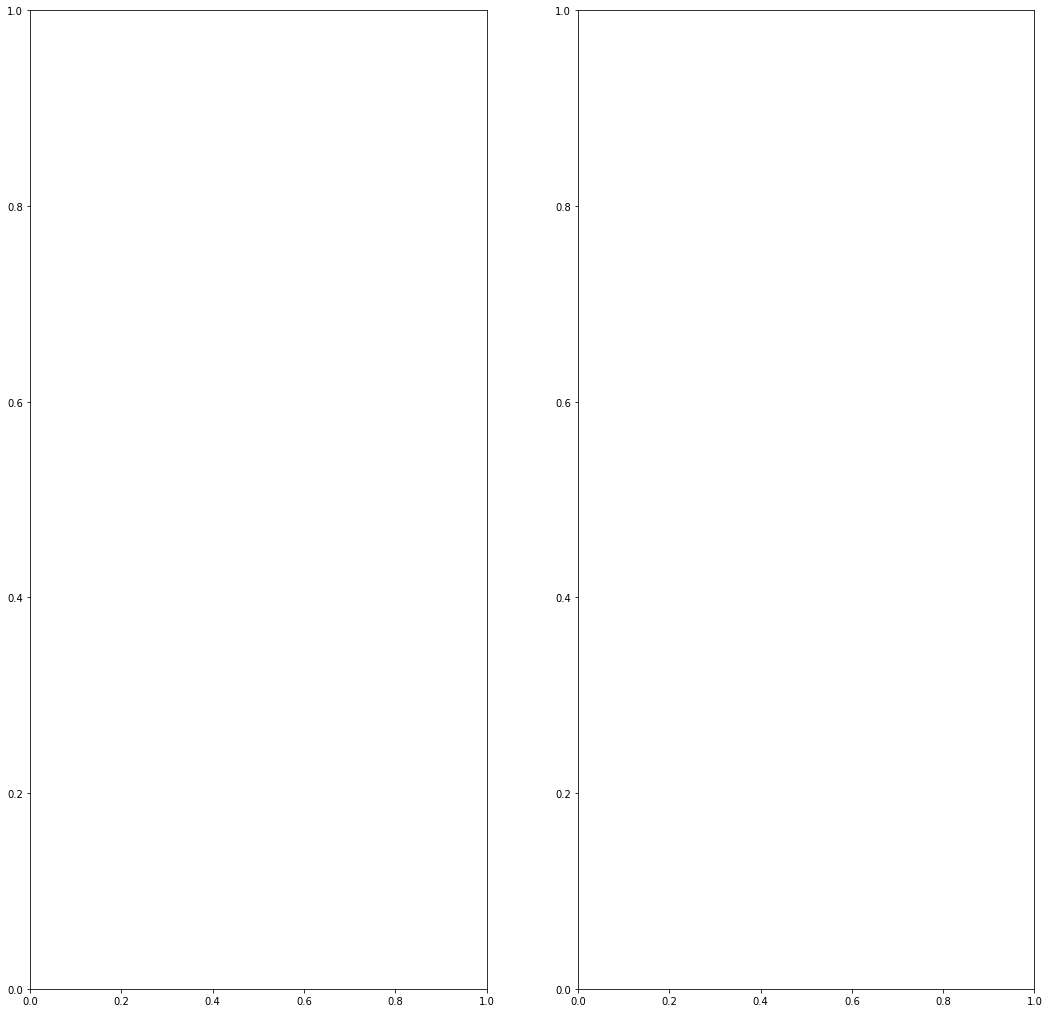

In [21]:
imgr= segment_image(image2, half_side=20, channel=None, show_contours=True)
fig, ax = plt.subplots(1, 2, figsize=(18,18))
ax[0].imshow(imgr[1000:1400, 1000:1400])
ax[1].imshow(cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)[1000:1400, 1000:1400])
plt.show()
# fig = plt.figure(figsize=(18,18))
# plt.imshow(image2[1000:1400, 1000:1400])
# plt.show()

In [ ]:
simgs, fr = segment_image(image2, half_side=20, channel=None, show_contours=True)
for img in simgs[:10]:
    fig = plt.figure(figsize=(18,18))
    plt.imshow(img)
    plt.show()
    

In [ ]:
len(simgs)